# Importing Libraries and Data

In [1]:
import pandas as pd

import nltk

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("simpsons_dataset.csv")

In [3]:
df.head()

,raw_character_text,spoken_words
0,Miss Hoover,"No, actually, it was a little of both. Sometim..."
1,Lisa Simpson,Where's Mr. Bergstrom?
2,Miss Hoover,I don't know. Although I'd sure like to talk t...
3,Lisa Simpson,That life is worth living.
4,Edna Krabappel-Flanders,The polls will be open from now until the end ...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158314 entries, 0 to 158313
Data columns (total 2 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   raw_character_text  140500 non-null  object
 1   spoken_words        131855 non-null  object
dtypes: object(2)
memory usage: 2.4+ MB


# Data Exploration

Top 10 characters by number of lines:

In [5]:
df["raw_character_text"].value_counts(dropna=False).head(10)

Homer Simpson          29782
NaN                    17814
Marge Simpson          14141
Bart Simpson           13759
Lisa Simpson           11489
C. Montgomery Burns     3162
Moe Szyslak             2862
Seymour Skinner         2438
Ned Flanders            2144
Grampa Simpson          1880
Name: raw_character_text, dtype: int64

See if any of the instances where character is missing still contains lines:

In [6]:
df.loc[(df["raw_character_text"].isna()) & ~(df["spoken_words"].isna()),"spoken_words"]

86485     EVERYWHERE AROUND THE WORLD / THEY'RE COMIN' T...
143113                                           Right here
Name: spoken_words, dtype: object

Only two, so we just drop any rows with character missing:

In [7]:
df = df.dropna(how="any")

Let's extract all words that main members of the simpsons family say (excluding Maggie).

First define a function that extracts words from lines:

In [8]:
def get_words(line):
    # Extract words converted to lower case and without punctuation:
    words = ["".join([char for char in word.lower() if char.isalpha()]) for word in line.split()]

    # Filter out stopwords and empty strings:
    filtered_words = [word for word in words if word not in nltk.corpus.stopwords.words("english") and len(word) > 0]

    return filtered_words

Next, group data frame by member of the Simpsons and extract all words as a single list of words:

In [9]:
%%time

simpsons = ["Homer Simpson","Marge Simpson","Bart Simpson","Lisa Simpson"]

homer,marge,bart,lisa = df[df["raw_character_text"].isin(simpsons)].groupby("raw_character_text").apply(
    lambda character: [word for word_list in character["spoken_words"].apply(get_words) for word in word_list]
)

CPU times: total: 3min 20s
Wall time: 3min 28s


How often do the characters refer to each other?

In [10]:
# Define a list of ways each character can be referred to by each other:
simpsons_names = ["homer", "dad", "homie",
                  "marge", "mom",
                  "bart",
                  "lisa"]

homer_names = pd.Series(homer)[pd.Series(homer).isin(simpsons_names)].replace({"dad":"homer", "homie":"homer", "mom":"marge"})
marge_names = pd.Series(marge)[pd.Series(marge).isin(simpsons_names)].replace({"dad":"homer", "homie":"homer", "mom":"marge"})
bart_names = pd.Series(bart)[pd.Series(bart).isin(simpsons_names)].replace({"dad":"homer", "homie":"homer", "mom":"marge"})
lisa_names = pd.Series(lisa)[pd.Series(lisa).isin(simpsons_names)].replace({"dad":"homer", "homie":"homer", "mom":"marge"})

In [11]:
df_plot = pd.DataFrame({
    "Bart": bart_names.value_counts(normalize=True).sort_index(ascending=False),
    "Homer": homer_names.value_counts(normalize=True).sort_index(ascending=False),
    "Lisa": lisa_names.value_counts(normalize=True).sort_index(ascending=False),
    "Marge": marge_names.value_counts(normalize=True).sort_index(ascending=False)
}).rename(index={"bart":"Bart", "homer":"Homer", "lisa":"Lisa", "marge":"Marge"})

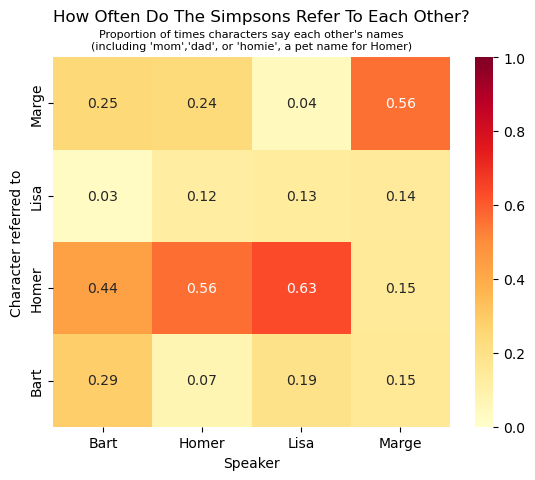

In [12]:
sns.heatmap(df_plot, cmap=sns.color_palette("YlOrRd", as_cmap=True), annot=True, fmt=".2f", vmin=0, vmax=1)

plt.xlabel("Speaker")
plt.ylabel("Character referred to")
plt.suptitle("How Often Do The Simpsons Refer To Each Other?", x=0.45)
plt.title("Proportion of times characters say each other's names\n(including 'mom','dad', or 'homie', a pet name for Homer)", fontsize=8)

plt.show()